<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/pyior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scanpy --quiet
!pip install pybiomart --quiet
!pip install python-igraph --quiet
!pip install louvain --quiet
!pip install pynndescent --quiet



In [2]:
import h5py
import numpy as np
import scipy as sci
from matplotlib import pyplot as plt
import scanpy as sc
import tarfile
import os
import anndata as ad
import pandas as pd
import pybiomart
from tqdm import tqdm
import urllib.request
from IPython.display import clear_output
from matplotlib.pyplot import rc_context
import logging
import seaborn as sns
# import gprofiler

In [3]:
############# SPECIFIC CONFIG #############
working_dir = r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\_pyior"
os.makedirs(working_dir,exist_ok=True)
os.chdir(working_dir)
zalocusky_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE167497&format=file'
geo_zalo_filename = 'zalocusky_indiv.tar'

import urllib
response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py



In [4]:
def trim_key(k):
    floxed_dict = {'GSM5106175_YH_KZ03_01':('E3fKI_Syn_Cre602_15m','GSM5106175_602_E3fKI_15_XX'),
                   'GSM5106176_YH_KZ03_03':('E4fKI_Syn_Cre475_15m','GSM5106176_475_E4fKI_15_XX')}
    for f in floxed_dict.keys():
        if f in k: return floxed_dict[f][1]
    k = k.replace('_raw_gene_bc_matrices_h5.h5',"")
    return k

def query_capitilaziation(gene,adata):
    try:
        return adata.var.index[ [g.lower() for g in list(adata.var.index)].index(gene.lower()) ]
    except:
        return gene + ' not_found'

def z_score(x,axis=-1):
    x=np.array(x)
    return (x-np.mean(x,axis=axis))/np.std(x,axis=axis)



In [5]:
def pull_gene_annots(csv_loc='./mmusculus_coding_noncoding.csv',
                     my_git='https://raw.githubusercontent.com/dtabuena/Resources/main/Genetics/mmusculus_coding_noncoding.csv',
                     biomart_name='mmusculus',
                     biomart_keys=["ensembl_gene_id", "chromosome_name","transcript_biotype","external_gene_name","peptide"]):

    if os.path.exists('./mmusculus_coding_noncoding.csv'):
        print( 'Use local copy of musmus')
        annot_dd = pd.read_csv('./mmusculus_coding_noncoding.csv').set_index("external_gene_name")
    else:
        try:
            print( 'attempting to pull mus mus from git...')
            musmus_link = 'https://raw.githubusercontent.com/dtabuena/Resources/main/Genetics/mmusculus_coding_noncoding.csv'
            filename = './mmusculus_coding_noncoding.csv'
            urllib.request.urlretrieve(musmus_link, filename)
            annot_dd = pd.read_csv('./mmusculus_coding_noncoding.csv').set_index("external_gene_name")
        except:
            print('attempting to pull mus mus from biomart...')
            annot = sc.queries.biomart_annotations("mmusculus",["ensembl_gene_id", "chromosome_name","transcript_biotype","external_gene_name"],).set_index('ensembl_gene_id')
            uniq_inds = list(set(list(annot.index)))
            for r in tqdm(uniq_inds):
                match_bool = annot.index.str.contains(r)
                if np.sum(match_bool)>1:
                    new_val ='__'.join(list(annot.loc[r,'transcript_biotype']))
                    annot.at[r,'transcript_biotype']=new_val
            annot['is_coding']= annot.transcript_biotype.str.contains('coding')
            annot_dd = annot.drop_duplicates().set_index("external_gene_name")
            annot_dd.to_csv('./mmusculus_coding_noncoding.csv')

    coding_list = annot_dd.index[ annot_dd['is_coding'] ].to_list()
    return coding_list, annot_dd


def preprocess_andata10x(adata_og,pct_mito=0.25,min_genes=500,max_genes=2400,min_counts=500,max_counts=4500,keep_NC=False):

    print('pulling gene annotations...')
    coding_list, _ = pull_gene_annots()
    adata_og.var['mt'] = adata_og.var_names.str.startswith('mt-')
    adata_og.var['coding'] = [gene in coding_list for gene in adata_og.var_names]
    sc.pp.calculate_qc_metrics(adata_og, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    adata_QC = adata_og.copy()

    print('Filtering...')
    adata_QC = adata_QC[adata_QC.obs.pct_counts_mt < pct_mito, :]
    print(str(np.sum(adata_og.obs.pct_counts_mt <pct_mito)) + f' cells with >{pct_mito}% mt removed')

    if keep_NC:
        print('keep noncoding')
    else:
        adata_QC = adata_QC[:, adata_QC.var.coding]
        print(str(np.sum(np.logical_not(adata_og.var.coding))) + ' non coding genes removed')

    sc.pp.filter_cells(adata_QC, min_genes=min_genes)
    sc.pp.filter_cells(adata_QC, max_genes=max_genes)
    sc.pp.filter_cells(adata_QC, min_counts=min_counts)
    sc.pp.filter_cells(adata_QC, max_counts=max_counts)
    fig,ax=plt.subplots(1,figsize=(1.5,1.5))
    sc.pl.scatter(adata_QC, x='total_counts', y='n_genes_by_counts',ax=ax)

    return adata_QC,adata_og

def high_var_genes_dim_reduc(adata,min_mean = 0.25,max_mean = 4,min_disp=0.55):
    ''' The gene expression matrices were then log-normalized with a scale factor of 10,000,
    using the Seurat NormalizeData function57,58. Highly dispersed genes were selected using
    the Seurat FindVariableGenes function57,58,filtering for an average expression range of
    0.25–4 and a minimum dispersion of 0.55, resulting in a list of 2,197 genes.'''
    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=10000)
    sc.pp.log1p(adata)
    adata.uns['log1p'] = {'base': None}
    print(adata.uns['log1p'])
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
    with rc_context({'figure.figsize': (1.5, 1.5)}):
        sc.pl.highly_variable_genes(adata)
    plt.tight_layout()
    print(np.sum(adata.var['highly_variable']),'hv genes')


    #### PCA
    sc.tl.pca(adata, svd_solver='arpack',n_comps=50)
    fig,ax=plt.subplots(figsize=(1,1))
    ax.plot(adata.uns['pca']['variance_ratio'][:25],'ok',markersize=1)
    quiet_PCA_plots(adata,['E_type','age_bin','mouse_ID'],pc_pairs=[(0,1),(2,3)])

    return adata

def quiet_PCA_plots(adata,key_list,figsize=(2,2),pc_pairs=[(0,1)]):
    fig,ax=plt.subplots(1*len(pc_pairs),len(key_list),figsize=(figsize[0]*len(key_list),figsize[1]*len(pc_pairs)))
    for ip,pair in enumerate(pc_pairs):
        if len(key_list) == 1: ax=[ax]
        for key_ind,key in enumerate(key_list):
            key_types = sorted(list(set( adata.obs[key] )))
            for k in key_types:
                is_k = adata.obs[key]==k
                ax[ip,key_ind].scatter(adata.obsm['X_pca'][is_k,pair[0]],adata.obsm['X_pca'][is_k,pair[1]],s=2,marker='.',linewidth=0,edgecolors=None,label=k)
                ax[ip,key_ind].set_xlabel(f'PC{pair[0]}')
                ax[ip,key_ind].set_ylabel(f'PC{pair[1]}')
            if len(key_types)<8: ax[ip,key_ind].legend(key_types,loc='best',markerscale=3)
            ax[ip,key_ind].set_title(key)
            plt.tight_layout()
    return None


def umap_and_cluster(adata, n_neighbors=10, n_pcs=20,resolution=.6,plot_keys=['Cluster (nn)'],size = 1,to_plot=True):
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs,random_state=42, use_rep='X_pca')
    sc.tl.louvain(adata,resolution=resolution,random_state=42)
    sc.tl.paga(adata)
    sc.tl.umap(adata,random_state=42)
    adata.obs['Cluster (nn)']= adata.obs['louvain']
    if to_plot:
        with rc_context({'figure.figsize': (2.5, 2.5)}):
            sc.pl.umap(adata,add_outline=False, legend_loc='on data', color=plot_keys,size=size)
    return adata

def explore_umap(adata_GABA,key_list=[],size=1,legend_loc=None):
    with rc_context({'figure.figsize': (1.5,1.5)}):
        sc.pl.umap(adata_GABA, legend_loc=legend_loc, color=key_list,vmin=-0.5,size=size,cmap='Purples') # add_outline=True,
        plt.tight_layout()



In [6]:
################# INITIALIZE DIRECTORY DOWNLOAD FROM GEO
os.chdir(working_dir)
os.makedirs('./indiv_animal_results', exist_ok=True)
urllib.request.urlretrieve(zalocusky_url, './indiv_animal_results/'+geo_zalo_filename)
my_tar = tarfile.open('./indiv_animal_results/'+geo_zalo_filename)
my_tar.extractall('./indiv_animal_results') # specify which folder to extract to
my_tar.close()
# for f in os.listdir('./indiv_animal_results'):
#     print(f)


pulling gene annotations...
Use local copy of musmus
Filtering...
14987892 cells with >0.25% mt removed
keep noncoding


C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\Scanpy\Lib\site-packages\scanpy\preprocessing\_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


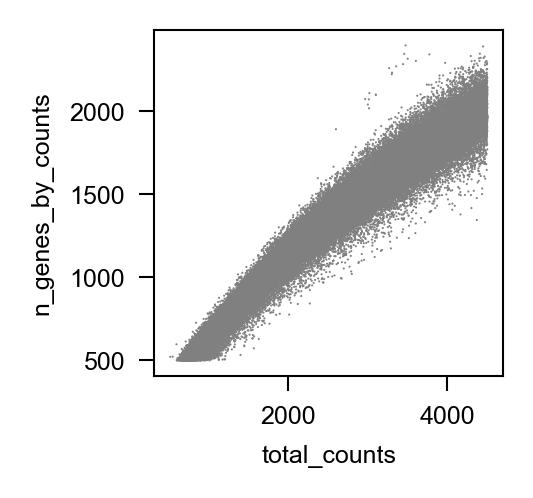

In [7]:
################# Read, Combine, and Sample Split multiple 10x's

adata_dict = {}
for f in os.listdir('./indiv_animal_results'):
    if '.h5' in f:
        a = sc.read_10x_h5('./indiv_animal_results/'+f)
        a.var_names_make_unique()
        sample_code = trim_key(f)
        a.obs['age_bin'] = str(int(np.ceil( int(sample_code.split("_")[3])/5)*5))+'m'
        a.obs['E_type'] = sample_code.split("_")[2]
        a.obs['mouse_ID'] = sample_code.split("_")[1]
        a.obs['well'] = sample_code.split("_")[4]
        a.obs['GSM'] = sample_code.split("_")[0]
        adata_dict[sample_code.split("_")[0]] = a
adata = ad.concat(adata_dict,axis = 0,label="Sample",index_unique="_")
adata.obs.E_type
# adata = adata[['fKI' not in t for t in adata.obs.E_type], :]
adata_dict = {}
clear_output()
adata.write_h5ad(filename='./kz_adata_raw.h5')


adata_QC = preprocess_andata10x(adata,keep_NC=True)[0]
adata_QC.write_h5ad(filename='./kz_adata_qc.h5')

{'base': None}


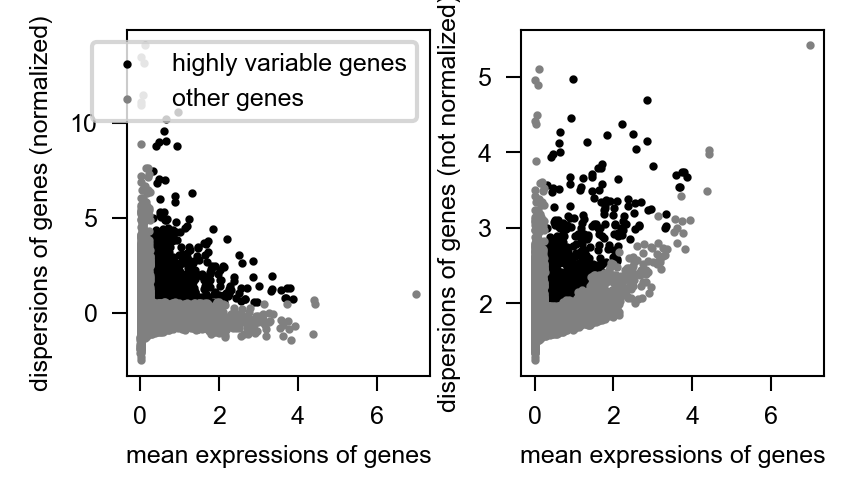

747 hv genes
{'base': None}


<Figure size 450x450 with 0 Axes>

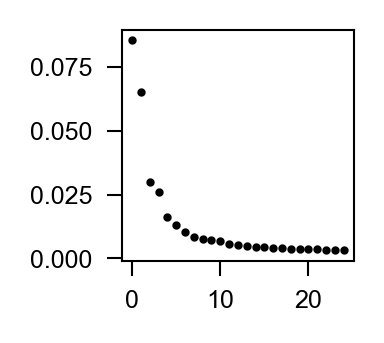

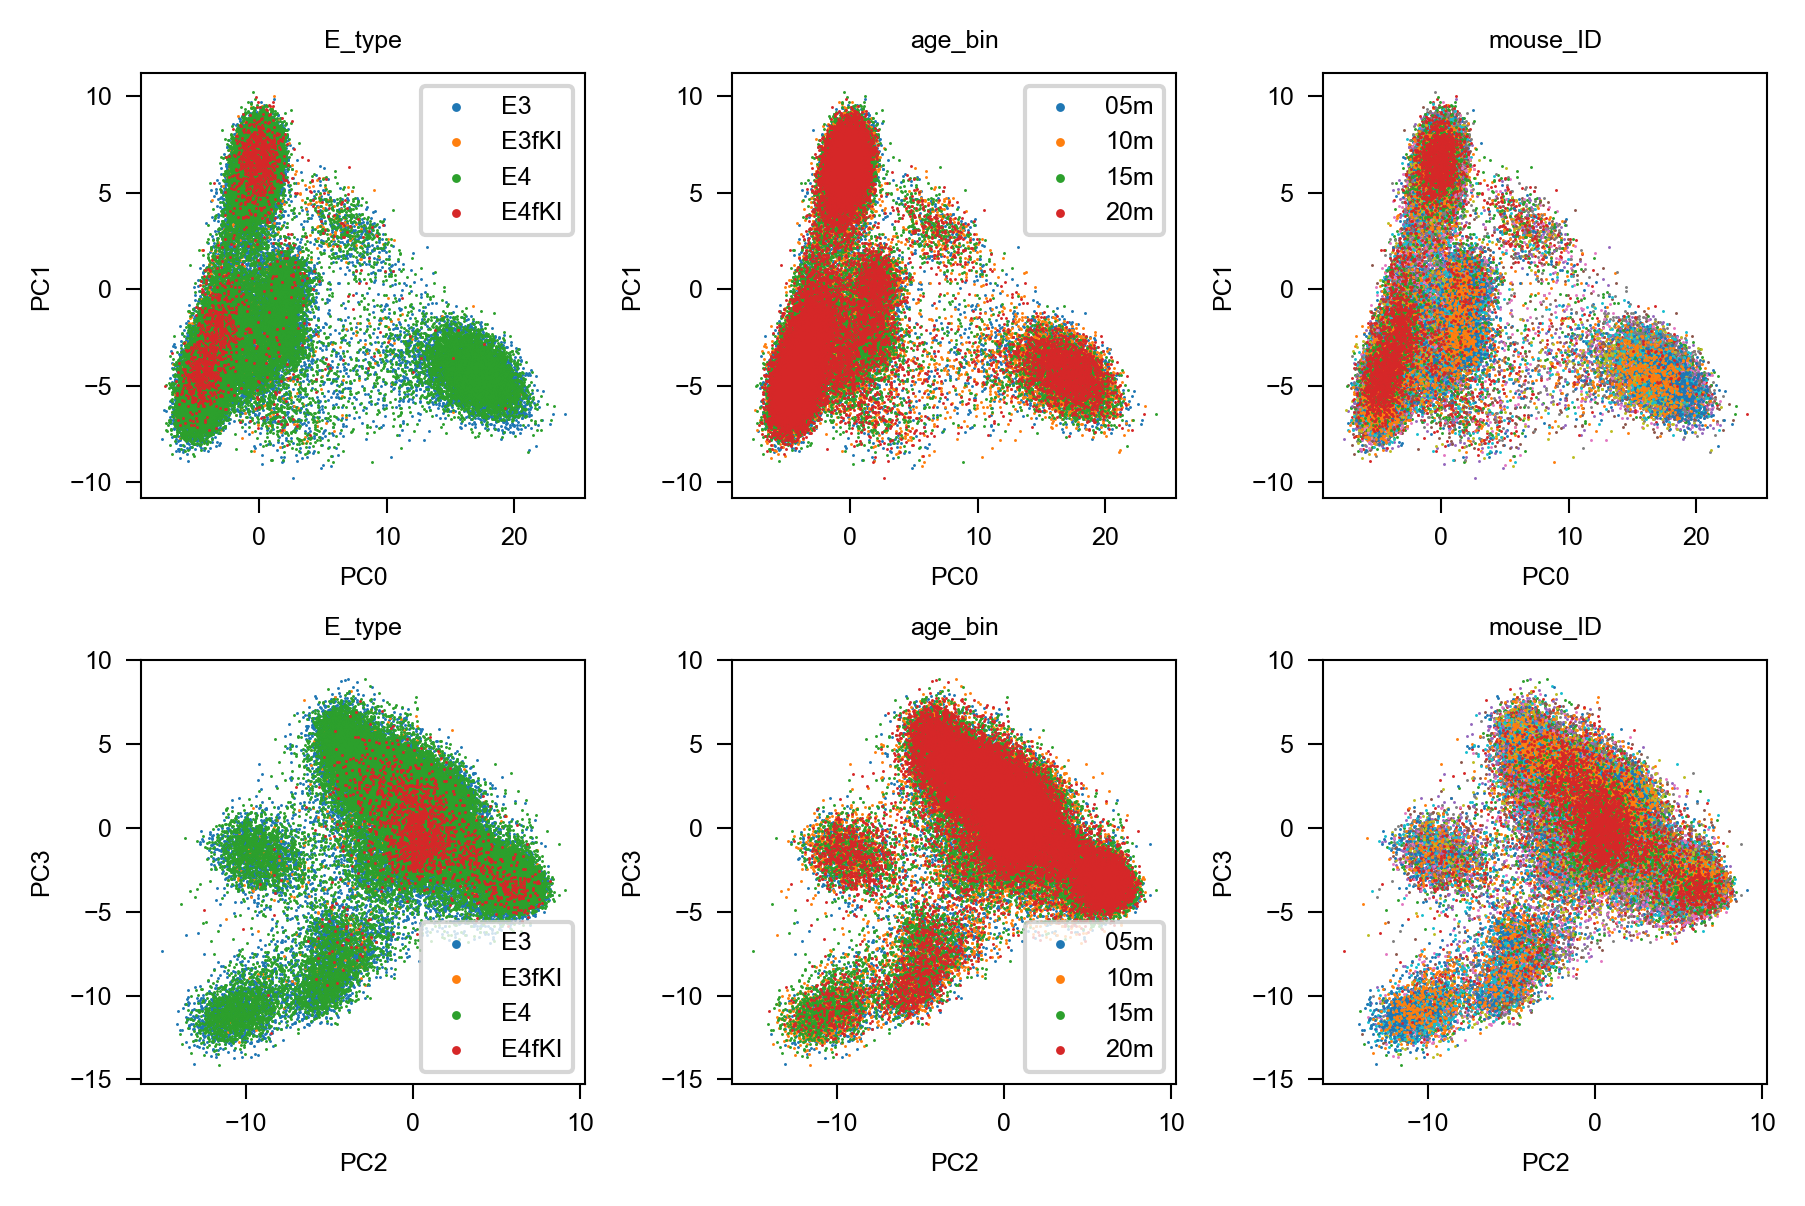

In [8]:
############## QC Filter #####################
adata_full = adata_QC.copy()
age_dict = {'5m':'05m', '10m': '10m','15m': '15m','20m': '20m'}
adata_full.obs['age_bin'] = [ age_dict[a] for a in adata_full.obs['age_bin'] ]

sc.pp.filter_genes(adata_full, min_counts=50)

############## Dim Reduction #####################
adata_full = high_var_genes_dim_reduc(adata_full)
adata_full.write_h5ad(filename='./adata_full.h5')
print(adata_full.uns['log1p'])


In [9]:
############## Dim Reduction #####################
adata_full = ad.read_h5ad('./adata_full.h5')

In [10]:
adata_full = ad.read_h5ad('./adata_full.h5')

In [17]:
adata_full.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 142810825 stored elements and shape (115902, 18063)>

In [11]:
adata_full

def build_tree(X):
    """
    build the full tree
    """
    for max_recusions:
        branch,_ = new_branch
        full_tree =  merg_new_branch(full_tree, branch)
    return tree_structure

def validate_branch(branch,sub_X):
    return valid

def merg_new_branch(full_tree, branch):
    return merged

def dimreduce_X(sub_X):
    return dr_X

def new_branch(sub_X, parent_id):
    return branch, dr_X

def sub_cluster(dr_X,clust_param):
    return child_ids # array of new labels for observations in X

def calc_sillouette(dr_X,child_ids):
    return sill

def optimize_subcluster(dr_X,clust_params):
    for clust_param in clust_params:
        child_ids = sub_cluster(dr_X,clust_param)
        sill = calc_sillouette(dr_X,child_ids)
    return best_sill,best_child_ids



'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\0_Projects\\_pyior'